In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry
from utils import utils

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

overwrite_figures = True
figure_path = 'outputs'

rc = {"mathtext.fontset" : "stix"}
plt.rcParams.update(rc)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [11]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
            matrix_dims = (256,256,64),
            baseline = (1500, 1000),
            seed = 5678,)

water = tissue.Tissue(name='water', c=1500, rho=1000, sigma=0, scale=0.001, label=0)
wire = tissue.Tissue(name='wire', c=2400, rho=1500, sigma=0, scale=0.001, label=1)

pos = 0.016
test_phantom.add_tissue(water, mask=np.ones(test_phantom.matrix_dims))

wire_mask = np.zeros(test_phantom.matrix_dims)
for i in range(4,13): 
    for j in range(1,13): 
        wire_mask[int(0.01/test_phantom.voxel_dims[0]*i - 2),int(0.01/test_phantom.voxel_dims[0]*j - 2),:] = 1
    
test_phantom.add_tissue(wire, mask=wire_mask)
test_phantom.set_default_tissue('water')
test = test_phantom.get_complete()

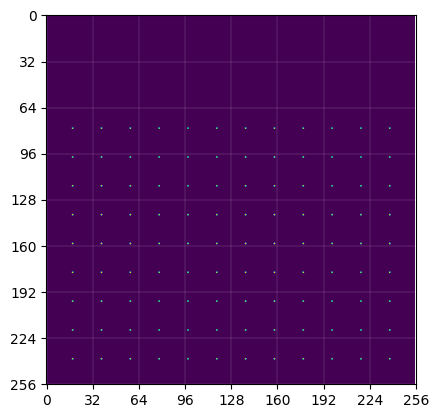

In [12]:
plt.imshow(test[0,:,:,test_phantom.matrix_dims[2]//2])

plt.gca().set_xticks(np.linspace(0, test_phantom.matrix_dims[1],9))
plt.gca().set_yticks(np.linspace(0, test_phantom.matrix_dims[0],9))
plt.gca().grid(color='w', linestyle='-', linewidth=0.1)

In [13]:
num_transducers = 5
transducers = [transducer.Planewave(max_frequency=2e6,
                                    elements = 256, 
                                    width = 10e-3,
                                    height =  10e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/4,
                                    ray_num = 5,
                                    imaging_ndims = 2,
                                    focus_elevation = 100e-3,
                                    ) for i in range(num_transducers)]

# num_transducers = 9
# transducers = [transducer.Planewave(max_frequency=1e6,
#                                     elements = 256, 
#                                     width = 8e-3,
#                                     height =  10e-3,
#                                     sensor_sampling_scheme = 'not_centroid', 
#                                     sweep = 0,
#                                     ray_num = 1,
#                                     imaging_ndims = 2,
#                                     focus_elevation = 100e-3,
#                                     ) for i in range(num_transducers)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

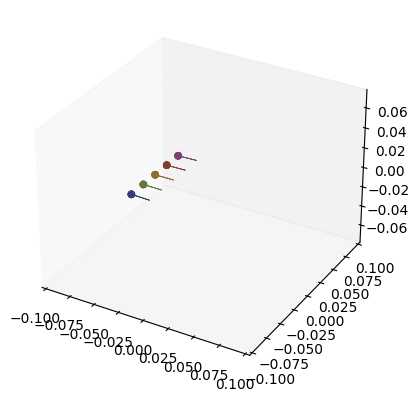

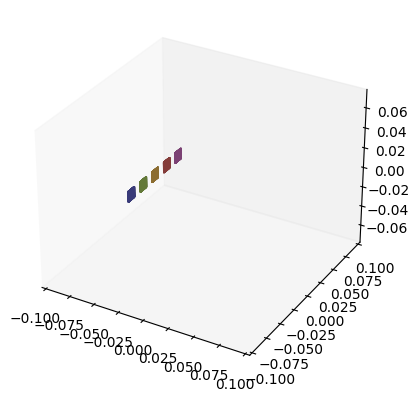

In [14]:
cont_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
cont_transducer_set.assign_pose(0, geometry.Transform([0,0,0], [-0.05,-0.04,0]))
cont_transducer_set.assign_pose(1, geometry.Transform([0,0,0], [-0.05,-0.02,0]))
cont_transducer_set.assign_pose(2, geometry.Transform([0,0,0], [-0.05,0,0]))
cont_transducer_set.assign_pose(3, geometry.Transform([0,0,0], [-0.05,0.02,0]))
cont_transducer_set.assign_pose(4, geometry.Transform([0,0,0], [-0.05,0.04,0]))

# cont_transducer_set.assign_pose(0, geometry.Transform([0,0,0], [-0.05,-0.04,0]))
# cont_transducer_set.assign_pose(1, geometry.Transform([0,0,0], [-0.05,-0.03,0]))
# cont_transducer_set.assign_pose(2, geometry.Transform([0,0,0], [-0.05,-0.02,0]))
# cont_transducer_set.assign_pose(3, geometry.Transform([0,0,0], [-0.05,-0.01,0]))
# cont_transducer_set.assign_pose(4, geometry.Transform([0,0,0], [-0.05, 0.00,0]))
# cont_transducer_set.assign_pose(5, geometry.Transform([0,0,0], [-0.05, 0.01,0]))
# cont_transducer_set.assign_pose(6, geometry.Transform([0,0,0], [-0.05, 0.02,0]))
# cont_transducer_set.assign_pose(7, geometry.Transform([0,0,0], [-0.05, 0.03,0]))
# cont_transducer_set.assign_pose(8, geometry.Transform([0,0,0], [-0.05, 0.04,0]))

cont_transducer_set.plot_transducer_fovs(scale=0.1)
cont_transducer_set.plot_transducer_coords(scale=0.1)

In [15]:
extended_sensor = sensor.Sensor(transducer_set=cont_transducer_set, aperture_type='extended_aperture')
tar_sensor = sensor.Sensor(transducer_set=cont_transducer_set, aperture_type='transmit_as_receive')

In [16]:
simprops = simulation.SimProperties(
                grid_size   = (100e-3,110e-3,20e-3),
                PML_size    = (16,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [17]:
extended_experiment = experiment.Experiment(
                 simulation_path = 'synchronous',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = cont_transducer_set,
                 sensor          = extended_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

tar_experiment = experiment.Experiment(
                 simulation_path = 'sequential',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = cont_transducer_set,
                 sensor          = tar_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

extended_experiment.save()
tar_experiment.save()

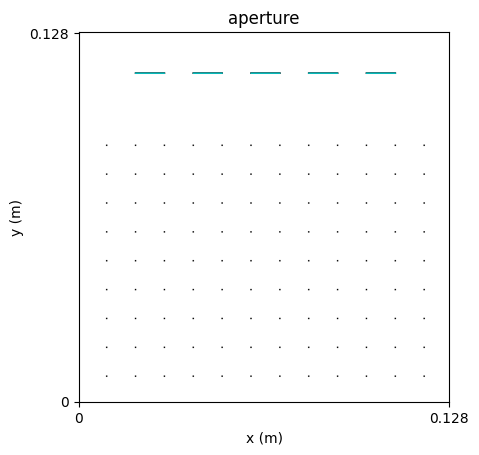

In [18]:
gm = extended_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), test_phantom.matrix_dims[2]//2])
plt.gca().set_title('aperture')
plt.gca().set_xticks([-1,256])
plt.gca().set_xticklabels(['0','0.128'])
plt.gca().set_yticks([0,256])
plt.gca().set_yticklabels(['0.128','0'])
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.savefig(f'{figure_path}/multitransducer_aperture.svg', dpi=300, bbox_inches="tight")

In [19]:
test_experiment = experiment.Experiment.load('sequential')
test_experiment.run(dry=True)
test_experiment.run(repeat=False)

dry run of simulation


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]

Found no more simulations to run.


In [20]:
test_experiment = experiment.Experiment.load('synchronous')
test_experiment.run(dry=True)
test_experiment.run(repeat=False)

dry run of simulation


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]

Found no more simulations to run.


# Reconstruction

In [2]:
test_experiment = experiment.Experiment.load('sequential')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


In [3]:
images1 = test_reconstruction.compound(workers=9, resolution_multiplier=2, combine=False, attenuation_factor=4)

100%|██████████| 25/25 [00:00<00:00, 572992.35it/s]

running reconstruction on 25 rays


running reconstruction on ray 0
running reconstruction on ray 1
running reconstruction on ray 2
running reconstruction on ray 3
running reconstruction on ray 4
running reconstruction on ray 5
running reconstruction on ray 6
running reconstruction on ray 7
running reconstruction on ray 8
running reconstruction on ray 9
running reconstruction on ray 10
running reconstruction on ray 11
running reconstruction on ray 12
running reconstruction on ray 13
running reconstruction on ray 14
running reconstruction on ray 15
running reconstruction on ray 16
running reconstruction on ray 17
running reconstruction on ray 18
running reconstruction on ray 19
running reconstruction on ray 20
running reconstruction on ray 21
running reconstruction on ray 22
running reconstruction on ray 23
running reconstruction on ray 24


In [4]:
image1 = np.sum(images1, axis=0)/len(images1)
image1t1 = np.sum(images1[:len(images1)//5], axis=0)/(len(images1)//5)
image1t2 = np.sum(images1[len(images1)//5:2*len(images1)//5], axis=0)/(len(images1)//5)
image1t3 = np.sum(images1[2*len(images1)//5:3*len(images1)//5], axis=0)/(len(images1)//5)
image1t4 = np.sum(images1[3*len(images1)//5:4*len(images1)//5], axis=0)/(len(images1)//5)
image1t5 = np.sum(images1[4*len(images1)//5:], axis=0)/(len(images1)//5)

In [5]:
from scipy.interpolate import NearestNDInterpolator
msensor = test_experiment.get_sensor_mask()
x = []
y = []
z = []
for i in tqdm.tqdm(range(msensor.shape[0])):
    for j in range(msensor.shape[1]):
        x.append(i)
        y.append(j)
        z.append(msensor[i,j,:].sum(axis=-1))
X = np.linspace(0, msensor.shape[0], image1.shape[0])
Y = np.linspace(0, msensor.shape[1], image1.shape[1])
X, Y = np.meshgrid(X, Y, indexing='ij')  # 2D grid for interpolation
interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)
sensor_mask = Z
sensor_mask5 = sensor_mask.copy()
sensor_mask5[:,200:] = 0
sensor_mask4 = sensor_mask.copy()
sensor_mask4[:,:200] = 0
sensor_mask4[:,300:] = 0
sensor_mask3 = sensor_mask.copy()
sensor_mask3[:,:300] = 0
sensor_mask3[:,400:] = 0
sensor_mask2 = sensor_mask.copy()
sensor_mask2[:,:400] = 0
sensor_mask2[:,500:] = 0
sensor_mask1 = sensor_mask.copy()
sensor_mask1[:,:500] = 0

100%|██████████| 256/256 [00:00<00:00, 2719.04it/s]


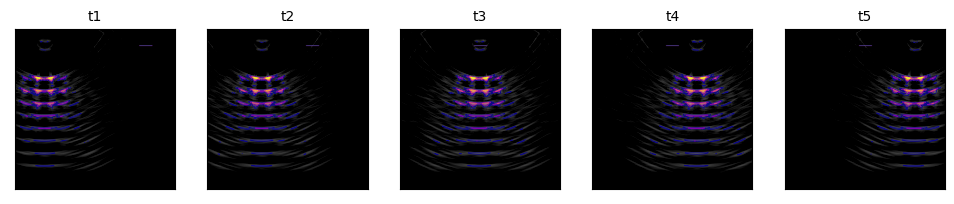

In [6]:
fig, ax = plt.subplots(1,5, figsize=(12,3))
contour_cmap = plt.cm.get_cmap('plasma')

psf = 20 * np.log10(image1t1 / np.max(image1t1))
image = psf[:,:,psf.shape[2]//2]
im = ax[0].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[0].imshow(sensor_mask1, cmap='cool_r', alpha=(sensor_mask1>0)*1.0)
CS = ax[0].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[0].set_title('t1', fontsize=10)

psf = 20 * np.log10(image1t2 / np.max(image1t2))
image = psf[:,:,psf.shape[2]//2]
im = ax[1].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[1].imshow(sensor_mask2, cmap='cool_r', alpha=(sensor_mask2>0)*1.0)
CS = ax[1].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[1].set_title('t2', fontsize=10)

psf = 20 * np.log10(image1t3 / np.max(image1t3))
image = psf[:,:,psf.shape[2]//2]
im = ax[2].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[2].imshow(sensor_mask3, cmap='cool_r', alpha=(sensor_mask3>0)*1.0)
CS = ax[2].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[2].set_title('t3', fontsize=10)

psf = 20 * np.log10(image1t4 / np.max(image1t4))
image = psf[:,:,psf.shape[2]//2]
im = ax[3].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[3].imshow(sensor_mask3, cmap='cool_r', alpha=(sensor_mask3>0)*1.0)
CS = ax[3].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[3].set_title('t4', fontsize=10)

psf = 20 * np.log10(image1t5 / np.max(image1t5))
image = psf[:,:,psf.shape[2]//2]
im = ax[4].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[4].imshow(sensor_mask3, cmap='cool_r', alpha=(sensor_mask3>0)*1.0)
CS = ax[4].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[4].set_title('t5', fontsize=10)

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

if overwrite_figures:
    plt.savefig(f'{figure_path}/sequential_individual_noap.png', dpi=300, bbox_inches="tight")

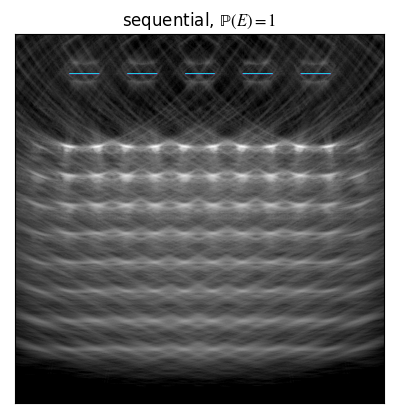

In [7]:
psf = 20 * np.log10(image1 / np.max(image1))
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()
contour_cmap = plt.cm.get_cmap('plasma')

im = ax.imshow(image, cmap='gray', vmin=-35, vmax=0)
ax.imshow(sensor_mask, cmap='cool_r', alpha=(sensor_mask>0)*1.0)
# CS = ax.contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5,0])

ax.set_title('sequential, $\mathrm{\mathbb{P}}(E)=1$')

ax.set_xticks([])
ax.set_yticks([])
if overwrite_figures:
    plt.savefig(f'{figure_path}/sequential_combined_noap.png', dpi=300, bbox_inches="tight")

In [8]:
test_experiment = experiment.Experiment.load('synchronous')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


In [9]:
images2 = test_reconstruction.compound(workers=9, resolution_multiplier=2, combine=False, attenuation_factor=4)

100%|██████████| 25/25 [00:00<00:00, 422812.90it/s]

running reconstruction on 25 rays


running reconstruction on ray 0
running reconstruction on ray 1
running reconstruction on ray 2
running reconstruction on ray 3
running reconstruction on ray 4
running reconstruction on ray 5
running reconstruction on ray 6
running reconstruction on ray 7
running reconstruction on ray 8
running reconstruction on ray 9
running reconstruction on ray 10
running reconstruction on ray 11
running reconstruction on ray 12
running reconstruction on ray 13
running reconstruction on ray 14
running reconstruction on ray 15
running reconstruction on ray 16
running reconstruction on ray 17
running reconstruction on ray 18
running reconstruction on ray 19
running reconstruction on ray 20
running reconstruction on ray 21
running reconstruction on ray 22
running reconstruction on ray 23
running reconstruction on ray 24


In [10]:
image2 = np.sum(images2, axis=0)/len(images2)
image2t1 = np.sum(images2[:len(images2)//5], axis=0)/(len(images2)//5)
image2t2 = np.sum(images2[len(images2)//5:2*len(images2)//5], axis=0)/(len(images2)//5)
image2t3 = np.sum(images2[2*len(images2)//5:3*len(images2)//5], axis=0)/(len(images2)//5)
image2t4 = np.sum(images2[3*len(images2)//5:4*len(images2)//5], axis=0)/(len(images2)//5)
image2t5 = np.sum(images2[4*len(images2)//5:], axis=0)/(len(images2)//5)

In [11]:
from scipy.interpolate import NearestNDInterpolator
msensor = test_experiment.get_sensor_mask()
x = []
y = []
z = []
for i in tqdm.tqdm(range(msensor.shape[0])):
    for j in range(msensor.shape[1]):
        x.append(i)
        y.append(j)
        z.append(msensor[i,j,:].sum(axis=-1))
X = np.linspace(0, msensor.shape[0], image1.shape[0])
Y = np.linspace(0, msensor.shape[1], image1.shape[1])
X, Y = np.meshgrid(X, Y, indexing='ij')  # 2D grid for interpolation
interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)
sensor_mask = Z
sensor_mask5 = sensor_mask.copy()
sensor_mask5[:,200:] = 0
sensor_mask4 = sensor_mask.copy()
sensor_mask4[:,:200] = 0
sensor_mask4[:,300:] = 0
sensor_mask3 = sensor_mask.copy()
sensor_mask3[:,:300] = 0
sensor_mask3[:,400:] = 0
sensor_mask2 = sensor_mask.copy()
sensor_mask2[:,:400] = 0
sensor_mask2[:,500:] = 0
sensor_mask1 = sensor_mask.copy()
sensor_mask1[:,:500] = 0

100%|██████████| 256/256 [00:00<00:00, 2717.38it/s]


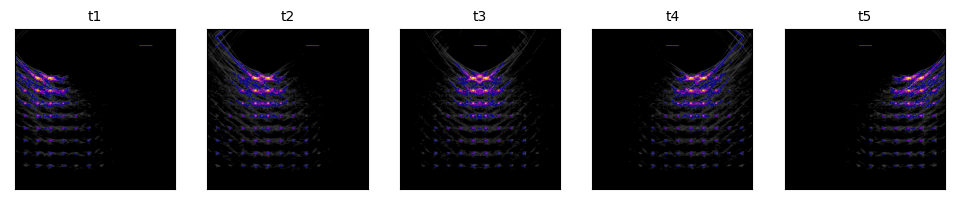

In [12]:
fig, ax = plt.subplots(1,5, figsize=(12,3))
contour_cmap = plt.cm.get_cmap('plasma')

psf = 20 * np.log10(image2t1 / np.max(image2t1))
image = psf[:,:,psf.shape[2]//2]
im = ax[0].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[0].imshow(sensor_mask1, cmap='cool_r', alpha=(sensor_mask1>0)*1.0)
CS = ax[0].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[0].set_title('t1', fontsize=10)

psf = 20 * np.log10(image2t2 / np.max(image2t2))
image = psf[:,:,psf.shape[2]//2]
im = ax[1].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[1].imshow(sensor_mask2, cmap='cool_r', alpha=(sensor_mask2>0)*1.0)
CS = ax[1].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[1].set_title('t2', fontsize=10)

psf = 20 * np.log10(image2t3 / np.max(image2t3))
image = psf[:,:,psf.shape[2]//2]
im = ax[2].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[2].imshow(sensor_mask3, cmap='cool_r', alpha=(sensor_mask3>0)*1.0)
CS = ax[2].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[2].set_title('t3', fontsize=10)

psf = 20 * np.log10(image2t4 / np.max(image2t4))
image = psf[:,:,psf.shape[2]//2]
im = ax[3].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[3].imshow(sensor_mask3, cmap='cool_r', alpha=(sensor_mask3>0)*1.0)
CS = ax[3].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[3].set_title('t4', fontsize=10)

psf = 20 * np.log10(image2t5 / np.max(image2t5))
image = psf[:,:,psf.shape[2]//2]
im = ax[4].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[4].imshow(sensor_mask3, cmap='cool_r', alpha=(sensor_mask3>0)*1.0)
CS = ax[4].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[4].set_title('t5', fontsize=10)

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

if overwrite_figures:
    plt.savefig(f'{figure_path}/synchronous_individual_noap.png', dpi=300, bbox_inches="tight")

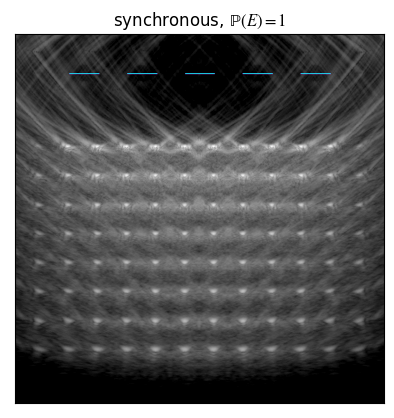

In [13]:
psf = 20 * np.log10(image2 / np.max(image2))
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()
contour_cmap = plt.cm.get_cmap('plasma')

im = ax.imshow(image, cmap='gray', vmin=-35, vmax=0)
ax.imshow(sensor_mask, cmap='cool_r', alpha=(sensor_mask>0)*1.0)
# CS = ax.contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])

ax.set_title('synchronous, $\mathrm{\mathbb{P}}(E)=1$')

# plt.colorbar(im, cax=ax.inset_axes([1.035, 0, 0.04, 1]), label='dB', ticks=[-35,-25,-20,-15,-10,-5,0])
# proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_edgecolor()[0]) for pc in CS.collections]
# plt.legend(proxy[::-1], ['','','','','','','',''][::-1], frameon=False, handlelength=1, handleheight=0.01, fontsize=10, bbox_to_anchor=(1.138, 0.905), labelspacing = 2.8)
# ax.clabel(CS, inline=True, fontsize=10)

ax.set_xticks([])
ax.set_yticks([])
if overwrite_figures:
    plt.savefig(f'{figure_path}/synchronous_combined_noap.png', dpi=300, bbox_inches="tight")

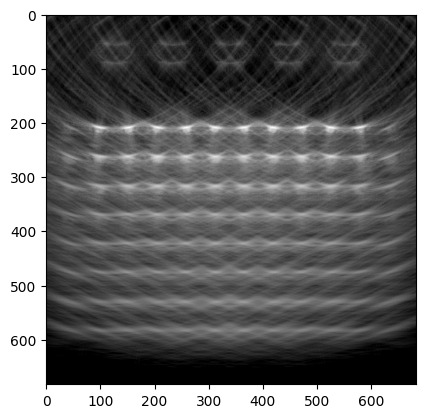

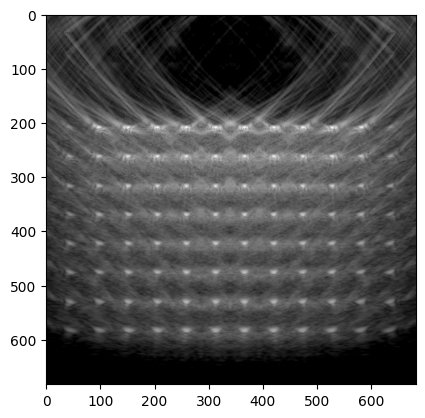

In [14]:
psf = 20 * np.log10(image1 / np.max(image1))
psf_image1 = psf[:,:,psf.shape[2]//2]

plt.imshow(psf_image1, cmap='gray', vmin=-35, vmax=0)
plt.show()
psf = 20 * np.log10(image2 / np.max(image2))
psf_image2 = psf[:,:,psf.shape[2]//2]

plt.imshow(psf_image2, cmap='gray', vmin=-35, vmax=0)
plt.show()

In [15]:
res_horz_indices = np.where(np.sum(test_reconstruction.phantom.mask, axis=(0,2))>128)[0]
res_horz_indices = res_horz_indices * image1.shape[0] / test_reconstruction.phantom.matrix_dims[0]
res_vert_indices = np.where(np.sum(test_reconstruction.phantom.mask, axis=(1,2))>128)[0]
res_vert_indices = res_vert_indices * image1.shape[0] / test_reconstruction.phantom.matrix_dims[0]

In [16]:
plt.rcParams.update({'font.size': 14})

Text(0.5, 0, 'x (mm)')

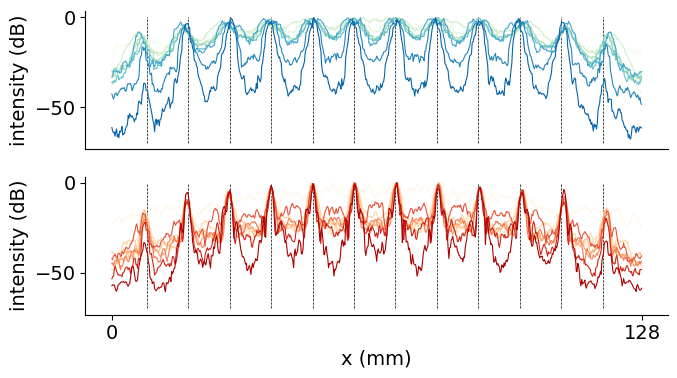

In [17]:
cmap1 = plt.cm.get_cmap('GnBu', 10)
cmap2 = plt.cm.get_cmap('OrRd', 10)

# near resolution horizontal
fig, ax = plt.subplots(2,1, figsize=(7,4), tight_layout=True)
for xc in res_horz_indices:
    ax[0].vlines(x=xc-3, ymin=-70,ymax=0, linewidth=0.5, color='k', linestyle='--')
    ax[1].vlines(x=xc-3, ymin=-70,ymax=0, linewidth=0.5, color='k', linestyle='--')

for row,index in enumerate(res_vert_indices[::-1]):
    ax[0].plot(20*np.log(image1[int(index)] / np.max(image1[int(index)])), linewidth = 0.8, c=cmap1(row), label='sequential')
    ax[1].plot(20*np.log(image2[int(index)] / np.max(image2[int(index)])), linewidth = 0.8, c=cmap2(row), label='synchronous')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].set_ylabel('intensity (dB)')
ax[1].set_ylabel('intensity (dB)')
ax[1].set_xticks([0,image2.shape[0]]) # 133 / 683 * 256 * 0.5
ax[1].set_xticklabels(['0','128'])
ax[0].set_xticks([]) # 133 / 683 * 256 * 0.5
ax[0].set_xticklabels([])
ax[1].set_xlabel('x (mm)')

In [18]:
from core.analytic_wave import planewave_pmax

In [19]:
test_experiment = experiment.Experiment.load('sequential')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


/tmp/ipykernel_967442/919677269.py:22: UserWarning: Casting input data from float128 to float64 for imshow.
  plt.savefig(f'{figure_path}/multitransducer_pressure_field.png', dpi=300, bbox_inches="tight")
/home/trevor/miniconda3/envs/musik/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Casting input data from float128 to float64 for imshow.
  fig.canvas.print_figure(bytes_io, **kw)


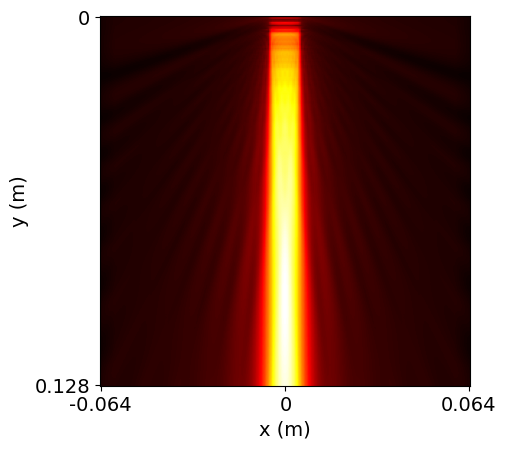

In [20]:
pmax = planewave_pmax(resolution=0.0005, 
                    matrix_size=(256,256), 
                    L=test_reconstruction.transducer_set[0][0].width, 
                    f=test_reconstruction.transducer_set[0][0].max_frequency, 
                    m=[-2,-1,0,1,2], 
                    w=test_reconstruction.transducer_set[0][0].width / test_reconstruction.transducer_set[0][0].get_num_elements(), 
                    c_0=1500, 
                    rho_0=1000, 
                    v_0=5e-8, 
                    tau=1, 
                    t=np.linspace(0, 10, 100), 
                    omega_c=1)

plt.imshow(pmax, cmap='hot')
plt.yticks([0,255])
plt.xticks([0,128,255])
plt.gca().set_yticklabels([f'{0}',f'{256*0.0005}'])
plt.gca().set_xticklabels([f'{-128*0.0005}', f'{0}', f'{128*0.0005}'])
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.savefig(f'{figure_path}/multitransducer_pressure_field.png', dpi=300, bbox_inches="tight")

In [21]:
images3 = test_reconstruction.compound(workers=9, resolution_multiplier=2, combine=False, pressure_field=pmax, pressure_field_resolution=0.0005, attenuation_factor=4)

100%|██████████| 25/25 [00:00<00:00, 519097.03it/s]

running reconstruction on 25 rays


running reconstruction on ray 0
running reconstruction on ray 1
running reconstruction on ray 2
running reconstruction on ray 3
running reconstruction on ray 4
running reconstruction on ray 5
running reconstruction on ray 6
running reconstruction on ray 7
running reconstruction on ray 8
running reconstruction on ray 9
running reconstruction on ray 10
running reconstruction on ray 11
running reconstruction on ray 12
running reconstruction on ray 13
running reconstruction on ray 14
running reconstruction on ray 15
running reconstruction on ray 16
running reconstruction on ray 17
running reconstruction on ray 18
running reconstruction on ray 19
running reconstruction on ray 20
running reconstruction on ray 21
running reconstruction on ray 22
running reconstruction on ray 23
running reconstruction on ray 24


In [22]:
image3 = np.sum(images3,                                        axis=0)/(len(images3))
image3t1 = np.sum(images3[: len(images3)//5],                   axis=0)/(len(images3)//5)
image3t2 = np.sum(images3[  len(images3)//5:2*len(images3)//5], axis=0)/(len(images3)//5)
image3t3 = np.sum(images3[2*len(images3)//5:3*len(images3)//5], axis=0)/(len(images3)//5)
image3t4 = np.sum(images3[3*len(images3)//5:4*len(images3)//5], axis=0)/(len(images3)//5)
image3t5 = np.sum(images3[4*len(images3)//5:],                  axis=0)/(len(images3)//5)

In [23]:
from scipy.interpolate import NearestNDInterpolator
msensor = test_experiment.get_sensor_mask()
x = []
y = []
z = []
for i in tqdm.tqdm(range(msensor.shape[0])):
    for j in range(msensor.shape[1]):
        x.append(i)
        y.append(j)
        z.append(msensor[i,j,:].sum(axis=-1))
X = np.linspace(0, msensor.shape[0], image3.shape[0])
Y = np.linspace(0, msensor.shape[1], image3.shape[1])
X, Y = np.meshgrid(X, Y, indexing='ij')  # 2D grid for interpolation
interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)
sensor_mask = Z
sensor_mask5 = sensor_mask.copy()
sensor_mask5[:,200:] = 0
sensor_mask4 = sensor_mask.copy()
sensor_mask4[:,:200] = 0
sensor_mask4[:,300:] = 0
sensor_mask3 = sensor_mask.copy()
sensor_mask3[:,:300] = 0
sensor_mask3[:,400:] = 0
sensor_mask2 = sensor_mask.copy()
sensor_mask2[:,:400] = 0
sensor_mask2[:,500:] = 0
sensor_mask1 = sensor_mask.copy()
sensor_mask1[:,:500] = 0

100%|██████████| 256/256 [00:00<00:00, 2879.66it/s]


/tmp/ipykernel_967442/2334504951.py:4: RuntimeWarning: divide by zero encountered in log10
  psf = 20 * np.log10(image3t1 / np.max(image3t1))
/tmp/ipykernel_967442/2334504951.py:12: RuntimeWarning: divide by zero encountered in log10
  psf = 20 * np.log10(image3t2 / np.max(image3t2))
/tmp/ipykernel_967442/2334504951.py:28: RuntimeWarning: divide by zero encountered in log10
  psf = 20 * np.log10(image3t4 / np.max(image3t4))
/tmp/ipykernel_967442/2334504951.py:36: RuntimeWarning: divide by zero encountered in log10
  psf = 20 * np.log10(image3t5 / np.max(image3t5))


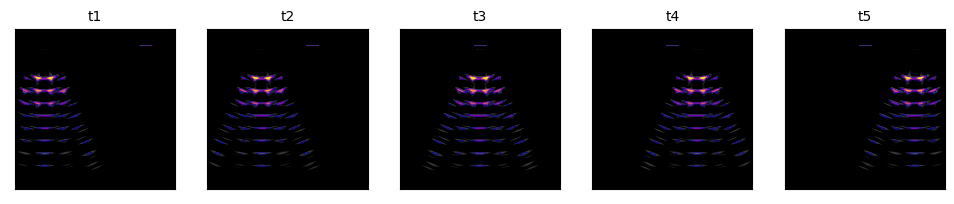

In [24]:
fig, ax = plt.subplots(1,5, figsize=(12,3))
contour_cmap = plt.cm.get_cmap('plasma')

psf = 20 * np.log10(image3t1 / np.max(image3t1))
image = psf[:,:,psf.shape[2]//2]
image = np.clip(image, -50, 0)
im = ax[0].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[0].imshow(sensor_mask1, cmap='cool_r', alpha=(sensor_mask1>0)*1.0)
CS = ax[0].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[0].set_title('t1', fontsize=10)

psf = 20 * np.log10(image3t2 / np.max(image3t2))
image = psf[:,:,psf.shape[2]//2]
image = np.clip(image, -50, 0)
im = ax[1].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[1].imshow(sensor_mask2, cmap='cool_r', alpha=(sensor_mask2>0)*1.0)
CS = ax[1].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[1].set_title('t2', fontsize=10)

psf = 20 * np.log10(image3t3 / np.max(image3t3))
image = psf[:,:,psf.shape[2]//2]
image = np.clip(image, -50, 0)
im = ax[2].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[2].imshow(sensor_mask3, cmap='cool_r', alpha=(sensor_mask3>0)*1.0)
CS = ax[2].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[2].set_title('t3', fontsize=10)

psf = 20 * np.log10(image3t4 / np.max(image3t4))
image = psf[:,:,psf.shape[2]//2]
image = np.clip(image, -50, 0)
im = ax[3].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[3].imshow(sensor_mask3, cmap='cool_r', alpha=(sensor_mask3>0)*1.0)
CS = ax[3].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[3].set_title('t4', fontsize=10)

psf = 20 * np.log10(image3t5 / np.max(image3t5))
image = psf[:,:,psf.shape[2]//2]
image = np.clip(image, -50, 0)
im = ax[4].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[4].imshow(sensor_mask3, cmap='cool_r', alpha=(sensor_mask3>0)*1.0)
CS = ax[4].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[4].set_title('t5', fontsize=10)

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

if overwrite_figures:
    plt.savefig(f'{figure_path}/sequential_aperture_individual_resolution_apodized.png', dpi=300, bbox_inches="tight")

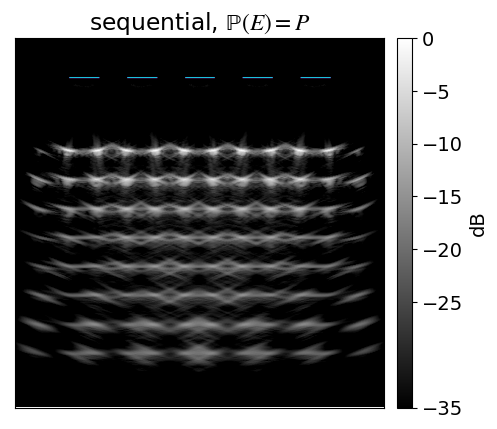

In [25]:
psf = 20 * np.log10(image3 / np.max(image3))
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()
contour_cmap = plt.cm.get_cmap('plasma')

im = ax.imshow(image, cmap='gray', vmin=-35, vmax=0)
ax.imshow(sensor_mask, cmap='cool_r', alpha=(sensor_mask>0)*1.0)
# CS = ax.contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5,0])

plt.colorbar(im, cax=ax.inset_axes([1.035, 0, 0.04, 1]), label='dB', ticks=[-35,-25,-20,-15,-10,-5,0])
# proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_edgecolor()[0]) for pc in CS.collections]
# plt.legend(proxy[::-1], ['','','','','','','',''][::-1], frameon=False, handlelength=1, handleheight=0.01, fontsize=10, bbox_to_anchor=(1.138, 0.905), labelspacing = 2.8)

ax.set_title('sequential, $\mathrm{\mathbb{P}}(E)=P$')

ax.set_xticks([])
ax.set_yticks([])
if overwrite_figures:
    plt.savefig(f'{figure_path}/sequential_combined_ap.png', dpi=300, bbox_inches="tight")

In [26]:
test_experiment = experiment.Experiment.load('synchronous')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


/home/trevor/miniconda3/envs/musik/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Casting input data from float128 to float64 for imshow.
  func(*args, **kwargs)


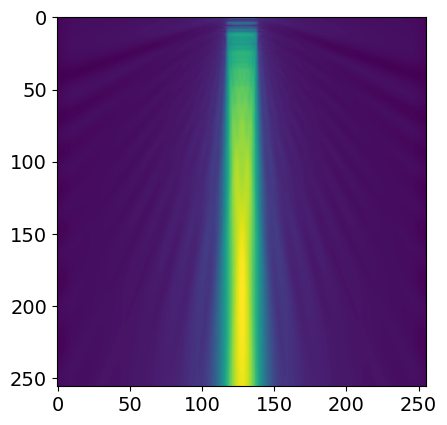

In [27]:
pmax = planewave_pmax(resolution=0.0005, 
                    matrix_size=(256,256), 
                    L=test_reconstruction.transducer_set[0][0].width, 
                    f=test_reconstruction.transducer_set[0][0].max_frequency, 
                    m=[-2,-1,0,1,2], 
                    w=test_reconstruction.transducer_set[0][0].width / test_reconstruction.transducer_set[0][0].get_num_elements(), 
                    c_0=1500, 
                    rho_0=1000, 
                    v_0=5e-8, 
                    tau=1, 
                    t=np.linspace(0, 10, 100), 
                    omega_c=1)

plt.imshow(pmax)

In [28]:
images4 = test_reconstruction.compound(workers=9, resolution_multiplier=2, combine=False, pressure_field=pmax, pressure_field_resolution=0.0005, attenuation_factor=4)

100%|██████████| 25/25 [00:00<00:00, 501711.00it/s]

running reconstruction on 25 rays


running reconstruction on ray 0
running reconstruction on ray 1
running reconstruction on ray 2
running reconstruction on ray 3
running reconstruction on ray 4
running reconstruction on ray 5
running reconstruction on ray 6
running reconstruction on ray 7
running reconstruction on ray 8
running reconstruction on ray 9
running reconstruction on ray 10
running reconstruction on ray 11
running reconstruction on ray 12
running reconstruction on ray 13
running reconstruction on ray 14
running reconstruction on ray 15
running reconstruction on ray 16
running reconstruction on ray 17
running reconstruction on ray 18
running reconstruction on ray 19
running reconstruction on ray 20
running reconstruction on ray 21
running reconstruction on ray 22
running reconstruction on ray 23
running reconstruction on ray 24


In [29]:
image4 =   np.sum(images4,                                      axis=0)/(len(images4))
image4t1 = np.sum(images4[: len(images4)//5],                   axis=0)/(len(images4)//5)
image4t2 = np.sum(images4[  len(images4)//5:2*len(images4)//5], axis=0)/(len(images4)//5)
image4t3 = np.sum(images4[2*len(images4)//5:3*len(images4)//5], axis=0)/(len(images4)//5)
image4t4 = np.sum(images4[3*len(images4)//5:4*len(images4)//5], axis=0)/(len(images4)//5)
image4t5 = np.sum(images4[4*len(images4)//5:],                  axis=0)/(len(images4)//5)

In [30]:
from scipy.interpolate import NearestNDInterpolator
msensor = test_experiment.get_sensor_mask()
x = []
y = []
z = []
for i in tqdm.tqdm(range(msensor.shape[0])):
    for j in range(msensor.shape[1]):
        x.append(i)
        y.append(j)
        z.append(msensor[i,j,:].sum(axis=-1))
X = np.linspace(0, msensor.shape[0], image4.shape[0])
Y = np.linspace(0, msensor.shape[1], image4.shape[1])
X, Y = np.meshgrid(X, Y, indexing='ij')  # 2D grid for interpolation
interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)
sensor_mask = Z
sensor_mask5 = sensor_mask.copy()
sensor_mask5[:,200:] = 0
sensor_mask4 = sensor_mask.copy()
sensor_mask4[:,:200] = 0
sensor_mask4[:,300:] = 0
sensor_mask3 = sensor_mask.copy()
sensor_mask3[:,:300] = 0
sensor_mask3[:,400:] = 0
sensor_mask2 = sensor_mask.copy()
sensor_mask2[:,:400] = 0
sensor_mask2[:,500:] = 0
sensor_mask1 = sensor_mask.copy()
sensor_mask1[:,:500] = 0

100%|██████████| 256/256 [00:00<00:00, 2878.81it/s]


/tmp/ipykernel_967442/914684604.py:4: RuntimeWarning: divide by zero encountered in log10
  psf = 20 * np.log10(image4t1 / np.max(image4t1))
/tmp/ipykernel_967442/914684604.py:12: RuntimeWarning: divide by zero encountered in log10
  psf = 20 * np.log10(image4t2 / np.max(image4t2))
/tmp/ipykernel_967442/914684604.py:28: RuntimeWarning: divide by zero encountered in log10
  psf = 20 * np.log10(image4t4 / np.max(image4t4))
/tmp/ipykernel_967442/914684604.py:36: RuntimeWarning: divide by zero encountered in log10
  psf = 20 * np.log10(image4t5 / np.max(image4t5))


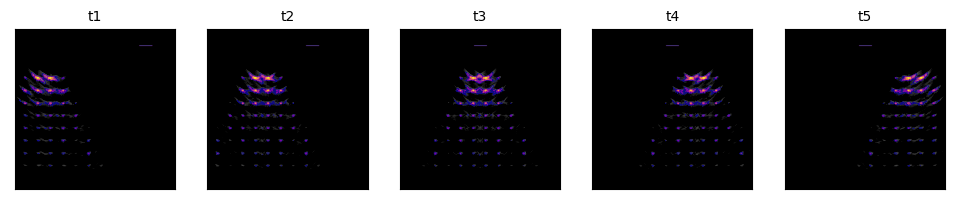

In [31]:
fig, ax = plt.subplots(1,5, figsize=(12,3))
contour_cmap = plt.cm.get_cmap('plasma')

psf = 20 * np.log10(image4t1 / np.max(image4t1))
image = psf[:,:,psf.shape[2]//2]
image = np.clip(image, -50, 0)
im = ax[0].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[0].imshow(sensor_mask1, cmap='cool_r', alpha=(sensor_mask1>0)*1.0)
CS = ax[0].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[0].set_title('t1', fontsize=10)

psf = 20 * np.log10(image4t2 / np.max(image4t2))
image = psf[:,:,psf.shape[2]//2]
image = np.clip(image, -50, 0)
im = ax[1].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[1].imshow(sensor_mask2, cmap='cool_r', alpha=(sensor_mask2>0)*1.0)
CS = ax[1].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[1].set_title('t2', fontsize=10)

psf = 20 * np.log10(image4t3 / np.max(image4t3))
image = psf[:,:,psf.shape[2]//2]
image = np.clip(image, -50, 0)
im = ax[2].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[2].imshow(sensor_mask3, cmap='cool_r', alpha=(sensor_mask3>0)*1.0)
CS = ax[2].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[2].set_title('t3', fontsize=10)

psf = 20 * np.log10(image4t4 / np.max(image4t4))
image = psf[:,:,psf.shape[2]//2]
image = np.clip(image, -50, 0)
im = ax[3].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[3].imshow(sensor_mask3, cmap='cool_r', alpha=(sensor_mask3>0)*1.0)
CS = ax[3].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[3].set_title('t4', fontsize=10)

psf = 20 * np.log10(image4t5 / np.max(image4t5))
image = psf[:,:,psf.shape[2]//2]
image = np.clip(image, -50, 0)
im = ax[4].imshow(image, cmap='gray', vmin=-35, vmax=0)
ax[4].imshow(sensor_mask3, cmap='cool_r', alpha=(sensor_mask3>0)*1.0)
CS = ax[4].contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])
ax[4].set_title('t5', fontsize=10)

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

if overwrite_figures:
    plt.savefig(f'{figure_path}/synchronous_individual_ap.png', dpi=300, bbox_inches="tight")

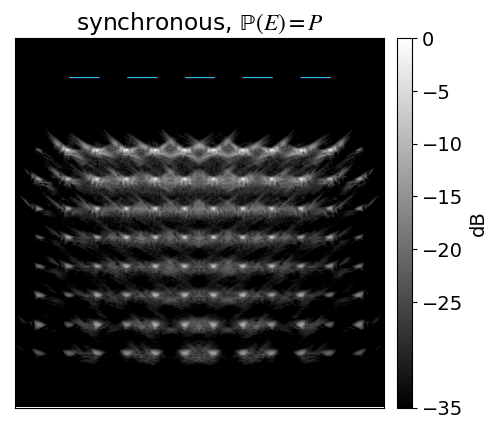

In [32]:
psf = 20 * np.log10(image4 / np.max(image4))
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()
contour_cmap = plt.cm.get_cmap('plasma')

im = ax.imshow(image, cmap='gray', vmin=-35, vmax=0)
ax.imshow(sensor_mask, cmap='cool_r', alpha=(sensor_mask>0)*1.0)
# CS = ax.contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-25,-20,-15,-10,-5])

ax.set_title('synchronous, $\mathrm{\mathbb{P}}(E)=P$')

plt.colorbar(im, cax=ax.inset_axes([1.035, 0, 0.04, 1]), label='dB', ticks=[-35,-25,-20,-15,-10,-5,0])
# proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_edgecolor()[0]) for pc in CS.collections]
# plt.legend(proxy[::-1], ['','','','','','','',''][::-1], frameon=False, handlelength=1, handleheight=0.01, fontsize=10, bbox_to_anchor=(1.138, 0.905), labelspacing = 2.8)
# ax.clabel(CS, inline=True, fontsize=10)

ax.set_xticks([])
ax.set_yticks([])
if overwrite_figures:
    plt.savefig(f'{figure_path}/synchronous_combined_ap.png', dpi=300, bbox_inches="tight")

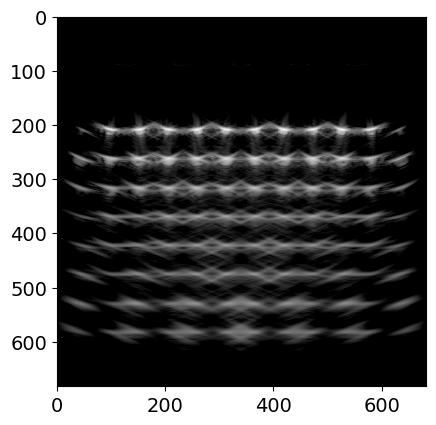

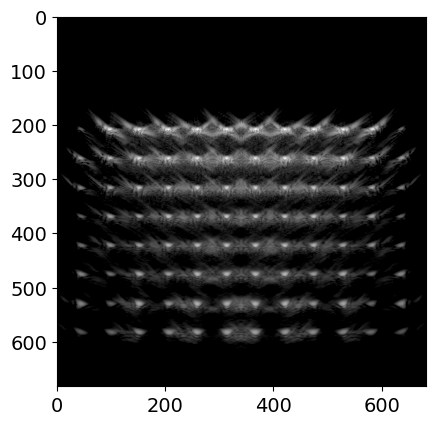

In [33]:
psf = 20 * np.log10(image3 / np.max(image3))
psf_image3 = psf[:,:,psf.shape[2]//2]

plt.imshow(psf_image3, cmap='gray', vmin=-35, vmax=0)
plt.show()
psf = 20 * np.log10(image4 / np.max(image4))
psf_image4 = psf[:,:,psf.shape[2]//2]

plt.imshow(psf_image4, cmap='gray', vmin=-35, vmax=0)
plt.show()

In [34]:
res_horz_indices = np.where(np.sum(test_reconstruction.phantom.mask, axis=(0,2))>128)[0]
res_horz_indices = res_horz_indices * image1.shape[0] / test_reconstruction.phantom.matrix_dims[0]
res_vert_indices = np.where(np.sum(test_reconstruction.phantom.mask, axis=(1,2))>128)[0]
res_vert_indices = res_vert_indices * image1.shape[0] / test_reconstruction.phantom.matrix_dims[0]

Text(0.5, 0, 'x (mm)')

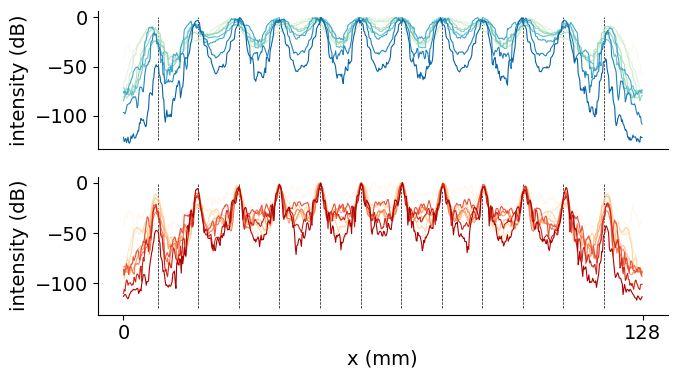

In [35]:
cmap1 = plt.cm.get_cmap('GnBu', 10)
cmap2 = plt.cm.get_cmap('OrRd', 10)

# near resolution horizontal
fig, ax = plt.subplots(2,1, figsize=(7,4), tight_layout=True)
for xc in res_horz_indices:
    ax[0].vlines(x=xc-3, ymin=-125,ymax=0, linewidth=0.5, color='k', linestyle='--')
    ax[1].vlines(x=xc-3, ymin=-125,ymax=0, linewidth=0.5, color='k', linestyle='--')

for row,index in enumerate(res_vert_indices[::-1]):
    ax[0].plot(20*np.log(image3[int(index)] / np.max(image3[int(index)])), linewidth = 0.8, c=cmap1(row), label='sequential')
    ax[1].plot(20*np.log(image4[int(index)] / np.max(image4[int(index)])), linewidth = 0.8, c=cmap2(row), label='synchronous')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].set_ylabel('intensity (dB)')
ax[1].set_ylabel('intensity (dB)')
ax[1].set_xticks([0,image3.shape[0]])
ax[1].set_xticklabels(['0','128'])
ax[0].set_xticks([])
ax[0].set_xticklabels([])
ax[1].set_xlabel('x (mm)')

# plt.savefig(f'{figure_path}/resolution_near_horizontal_psf.png', dpi=300, bbox_inches="tight")

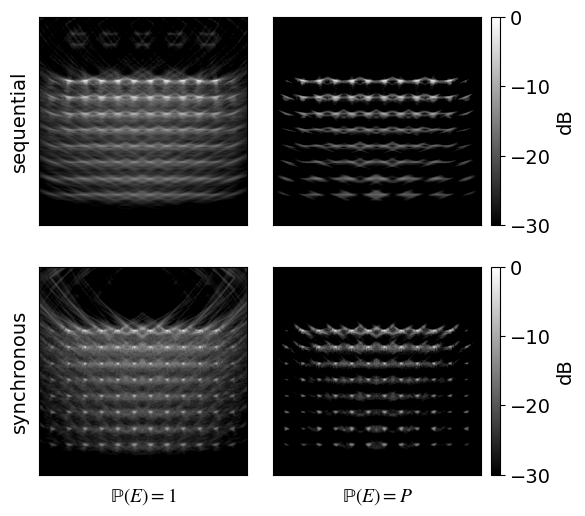

In [36]:
fig, ax = plt.subplots(2,2, figsize=(6,6), tight_layout=True)
fig.subplots_adjust(wspace=1.5, hspace=0)

psf = 20 * np.log10(image1 / np.max(image1))
psf_image1 = psf[:,:,psf.shape[2]//2]
# ax[0,0].imshow(psf_image1, cmap='gray', vmin=np.percentile(psf_image1, 90), vmax=0)
ax[0,0].imshow(psf_image1, cmap='gray', vmin=-30, vmax=0)

psf = 20 * np.log10(image2 / np.max(image2))
psf_image2 = psf[:,:,psf.shape[2]//2]
# ax[0,1].imshow(psf_image2, cmap='gray', vmin=np.percentile(psf_image2, 90), vmax=0)
ax[1,0].imshow(psf_image2, cmap='gray', vmin=-30, vmax=0)

psf = 20 * np.log10(image3 / np.max(image3))
psf_image3 = psf[:,:,psf.shape[2]//2]
# ax[1,0].imshow(psf_image3, cmap='gray', vmin=np.percentile(psf_image3, 90), vmax=0)
ax[0,1].imshow(psf_image3, cmap='gray', vmin=-30, vmax=0)

psf = 20 * np.log10(image4 / np.max(image4))
psf_image4 = psf[:,:,psf.shape[2]//2]
# ax[1,1].imshow(psf_image4, cmap='gray', vmin=np.percentile(psf_image4, 90), vmax=0)
im = ax[1,1].imshow(psf_image4, cmap='gray', vmin=-30, vmax=0)

for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
    
fig.colorbar(im, cax=ax[1,1].inset_axes([1.05, 0, 0.04, 1]), label='dB', ticks=[-30,-20,-10,0], use_gridspec=True)
fig.colorbar(im, cax=ax[0,1].inset_axes([1.05, 0, 0.04, 1]), label='dB', ticks=[-30,-20,-10,0], use_gridspec=True)
    
ax[0,0].set_ylabel('sequential')
ax[1,0].set_ylabel('synchronous')
ax[1,0].set_xlabel('$\mathrm{\mathbb{P}}(E)=1$')
ax[1,1].set_xlabel('$\mathrm{\mathbb{P}}(E)=P$')

plt.savefig(f'grid_image_4panel.svg', bbox_inches="tight", dpi=600)

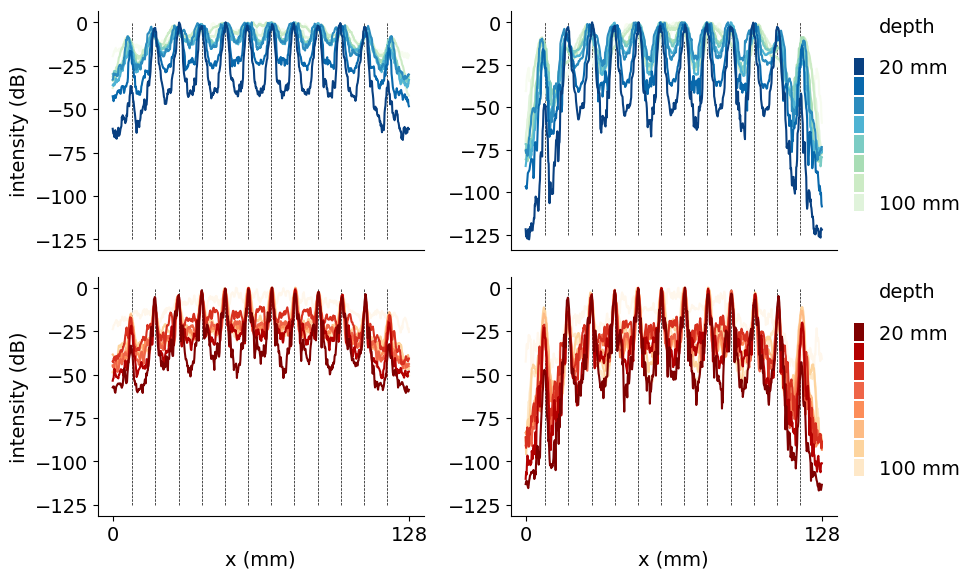

In [37]:
cmap1 = plt.cm.get_cmap('GnBu', 9)
cmap2 = plt.cm.get_cmap('OrRd', 9)

# near resolution horizontal
fig, ax = plt.subplots(2,2, figsize=(10,6), tight_layout=True)
for xc in res_horz_indices:
    ax[0,0].vlines(x=xc-3, ymin=-125,ymax=0, linewidth=0.5, color='k', linestyle='--')
    ax[0,1].vlines(x=xc-3, ymin=-125,ymax=0, linewidth=0.5, color='k', linestyle='--')
    ax[1,0].vlines(x=xc-3, ymin=-125,ymax=0, linewidth=0.5, color='k', linestyle='--')
    ax[1,1].vlines(x=xc-3, ymin=-125,ymax=0, linewidth=0.5, color='k', linestyle='--')

for row,index in enumerate(res_vert_indices[::-1]):
    ax[0,0].plot(20*np.log(image1[int(index)] / np.max(image1[int(index)])), linewidth = 1.5, c=cmap1(row), label='sequential')
    ax[0,1].plot(20*np.log(image3[int(index)] / np.max(image3[int(index)])), linewidth = 1.5, c=cmap1(row), label='sequential')
    ax[1,0].plot(20*np.log(image2[int(index)] / np.max(image2[int(index)])), linewidth = 1.5, c=cmap2(row), label='synchronous')
    ax[1,1].plot(20*np.log(image4[int(index)] / np.max(image4[int(index)])), linewidth = 1.5, c=cmap2(row), label='synchronous')

for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
ax[0,0].set_ylabel('intensity (dB)')
ax[1,0].set_ylabel('intensity (dB)')

ax[1,0].set_xticks([0,image3.shape[0]])
ax[1,0].set_xticklabels(['0','128'])
ax[1,1].set_xticks([0,image3.shape[0]])
ax[1,1].set_xticklabels(['0','128'])
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,0].set_xticklabels([])
ax[0,1].set_xticklabels([])
ax[1,0].set_xlabel('x (mm)')
ax[1,1].set_xlabel('x (mm)')

proxy = [plt.Rectangle((0,0),1,1,fc = cmap1(n)) for n in range(cmap1.N)]
ax[0,1].legend(proxy[::-1], ['20 mm','','','','','','','100 mm'], frameon=False, handlelength=0.5, handleheight=1, fontsize=14, bbox_to_anchor=(1, 1.05), labelspacing = 0, title='depth\n')
proxy = [plt.Rectangle((0,0),1,1,fc = cmap2(n)) for n in range(cmap2.N)]
ax[1,1].legend(proxy[::-1], ['20 mm','','','','','','','100 mm'], frameon=False, handlelength=0.5, handleheight=1, fontsize=14, bbox_to_anchor=(1, 1.05), labelspacing = 0, title='depth\n')

plt.savefig(f'{figure_path}/grid_psf_4panel.svg', bbox_inches="tight")

In [38]:
def compute_SNR(image, res_horz_indices, res_vert_indices, spread=13,):
    signal = np.zeros((res_vert_indices.shape[0], res_horz_indices.shape[0]))
    signal_points = []
    for i,m in enumerate(res_vert_indices):
        for j,n in enumerate(res_horz_indices):
            signal[i,j] = image[int(np.round(m)),int(np.round(n))]
            signal_points.append((n,m))
            
    noise = np.zeros((res_vert_indices.shape[0], res_horz_indices.shape[0]))
    noise_points = []
    for i,m in enumerate(res_vert_indices):
        for j,n in enumerate(res_horz_indices):
            noise[i,j] += image[int(np.round(m+spread)),int(np.round(n+spread))]
            noise[i,j] += image[int(np.round(m-spread)),int(np.round(n+spread))]
            noise[i,j] += image[int(np.round(m+spread)),int(np.round(n-spread))]
            noise[i,j] += image[int(np.round(m-spread)),int(np.round(n-spread))]
            noise_points.append((n+spread,m+spread))
            noise_points.append((n-spread,m+spread))
            noise_points.append((n+spread,m-spread))
            noise_points.append((n-spread,m-spread))
            
    signal_points = np.array(signal_points)
    noise_points = np.array(noise_points)
    
    noise = noise/4
    
    return signal, noise, signal_points, noise_points

In [39]:
signal1, noise1, signal_points1, noise_points1 = compute_SNR(image1, res_horz_indices, res_vert_indices)
signal2, noise2, signal_points2, noise_points2 = compute_SNR(image2, res_horz_indices, res_vert_indices)
signal3, noise3, signal_points3, noise_points3 = compute_SNR(image3, res_horz_indices, res_vert_indices)
signal4, noise4, signal_points4, noise_points4 = compute_SNR(image4, res_horz_indices, res_vert_indices)

error1 = np.std(signal1/noise1, axis=1)
error2 = np.std(signal2/noise2, axis=1)
error3 = np.std(signal3/noise3, axis=1)
error4 = np.std(signal4/noise4, axis=1)

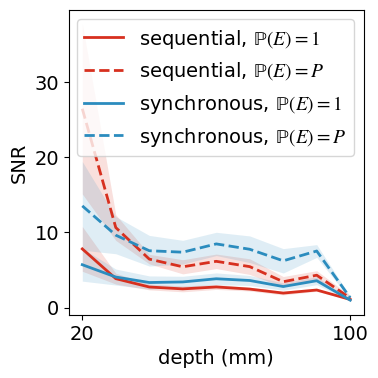

In [40]:
fig, ax = plt.subplots(1,1, figsize=(4,4), tight_layout=True)

ax.plot(np.mean(signal1/noise1, axis=1), color=cmap2(6), linestyle='-', label='sequential, $\mathrm{\mathbb{P}}(E)=1$', linewidth=2)
ax.plot(np.mean(signal3/noise3, axis=1), color=cmap2(6), linestyle='--', label='sequential, $\mathrm{\mathbb{P}}(E)=P$', linewidth=2)
ax.plot(np.mean(signal2/noise2, axis=1), color=cmap1(6), linestyle='-', label='synchronous, $\mathrm{\mathbb{P}}(E)=1$', linewidth=2)
ax.plot(np.mean(signal4/noise4, axis=1), color=cmap1(6), linestyle='--', label='synchronous, $\mathrm{\mathbb{P}}(E)=P$', linewidth=2)

ax.fill_between(np.arange(9), np.mean(signal1/noise1, axis=1)-error1, np.mean(signal1/noise1, axis=1)+error1, color=cmap2(6), alpha=0.15, linewidth=0)
ax.fill_between(np.arange(9), np.mean(signal2/noise2, axis=1)-error2, np.mean(signal2/noise2, axis=1)+error2, color=cmap1(6), alpha=0.15, linewidth=0)
ax.fill_between(np.arange(9), np.mean(signal3/noise3, axis=1)-error3, np.mean(signal3/noise3, axis=1)+error3, color=cmap2(6), alpha=0.15, linewidth=0)
ax.fill_between(np.arange(9), np.mean(signal4/noise4, axis=1)-error4, np.mean(signal4/noise4, axis=1)+error4, color=cmap1(6), alpha=0.15, linewidth=0)
ax.legend()

ax.set_xticks([0,8])
ax.set_xticklabels(['20','100'])
ax.set_xlabel('depth (mm)')
ax.set_ylabel('SNR')

plt.savefig(f'{figure_path}/multitransducer_SNR.svg', bbox_inches="tight")

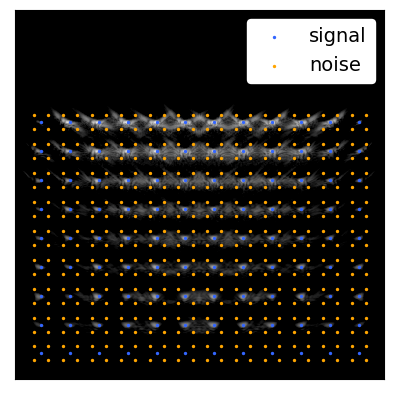

In [41]:
plt.imshow(psf_image4, cmap='gray', vmin=-30, vmax=0)
plt.scatter(signal_points1[:,0],signal_points1[:,1], c=[0.2,0.4,1], s=2, label='signal')
plt.scatter(noise_points1[:,0], noise_points1[:,1], c='orange', s=2, label='noise')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
legend = plt.legend(loc="upper right", edgecolor="white")
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((1, 1, 1, 1))
plt.savefig(f'{figure_path}/multitransducer_SNR_points.png', dpi=300, bbox_inches="tight")